# Sessa Empirical Estimator 🧪
## Overview & Journal Summary 📄
### The Sessa Empirical Estimator (SEE) 📊
Sometimes, it is difficult to track prescriptions especially when in the secondary data source there are missing or incomplete dosing details. This is where the SEE comes in. The SEE was introduced as a data-driven method for computing the duration of prescriptions from secondary data sources. The following are the main steps that SEE does.

1. **Compute Temporal Distances**: For each patient, calculate the time between consecutive prescription fills.
2. **Trim Outliers**: Use the empirical cumulative distribution function (ECDF) to remove the top 20% of these distances (which may be inflated by irregular refill patterns).
3. **Random Sampling & Standardization**: Randomly select pairs of consecutive fills, then standardize these temporal distances.
4. **Clustering**: Use k‑means clustering (with the optimal number of clusters determined, for example, via silhouette analysis) to group the standardized distances.
5. **Duration Estimation**: For each cluster, compute the median temporal distance to serve as the estimated “filled‐prescription duration.”

The journals we read had reports of high accuracy and sensitivity when validating the method on both simulated and real-world data. We will now try to replicate the R code of these journals into our Python implementations and then use a different clustering method for comparison and analysis of results.

## Importing the necessary libraries 📚
This step ensures all required libraries are available for data manipulation, visualization, and clustering.


In [ ]:
pip install numpy pandas scikit-learn matplotlib seaborn lifelines

In [56]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, cdist
from sklearn.cluster import DBSCAN

warnings.filterwarnings('ignore')

## Converting R Code to Python 🔄
Below is a simplified Python implementation of the SEE method using common packages like pandas, numpy, and scikit-learn

### Simulating a Dataset 📊
In this step, we simulate patient prescription data. Each patient has a series of prescription fill dates, and we randomly assign each prescription to one of two medications (medA or medB). The resulting dataset is stored in a DataFrame called df, which contains columns for patient number (pnr), prescription fill date (eksd), and medication type (ATC).

In [3]:
#######################
# 1. Simulate Data
#######################
np.random.seed(42)

def simulate_patient_data(num_patients):
    rows_per_patient = np.random.randint(2, 30, size=num_patients)  # each patient has 2-9 events
    records = []
    for p in range(num_patients):
        pnr = p + 1
        # random starting date
        base_date = pd.Timestamp('2020-01-01') + pd.Timedelta(days=np.random.randint(0, 100))
        # create a series of 2-9 events
        dates = [base_date]
        for i in range(rows_per_patient[p] - 1):
            gap_days = np.random.randint(10, 60)  # random interval
            new_date = dates[-1] + pd.Timedelta(days=gap_days)
            dates.append(new_date)
        for d in dates:
            records.append((pnr, d))
    return records

# Simulate data for 100 patients
records_set = simulate_patient_data(100)

# Create a single dataframe
df = pd.DataFrame(records_set, columns=['pnr', 'eksd'])
df = df.sort_values(by=['pnr', 'eksd']).reset_index(drop=True)

# Randomly assign each row to either 'medA' or 'medB'
df['ATC'] = np.random.choice(['medA', 'medB'], size=len(df))

# Print the records for verification
print("Records Set:")
df.head(10)

Records Set:


,pnr,eksd,ATC
0,1,2020-03-02,medA
1,1,2020-04-20,medA
2,1,2020-05-20,medA
3,1,2020-06-14,medA
4,1,2020-08-07,medB
5,1,2020-09-03,medB
6,1,2020-10-29,medB
7,1,2020-12-01,medA
8,2,2020-01-26,medA
9,2,2020-02-29,medB


### Sessa Empirical Estimator Function 📐
The code defines the Sessa Empirical Estimator (SEE) function in Python using k-means clustering. Here are the steps it performs:

1. **Filter by ATC Code**: The function filters the dataset to include only the rows corresponding to the specified ATC code (default is 'medA').

2. **Sort and Compute Event Intervals**: The filtered data is sorted by patient number (`pnr`) and prescription fill date (`eksd`). The time interval between consecutive prescription fills (`event.interval`) is calculated.

3. **Build Empirical Distribution**: The empirical cumulative distribution function (ECDF) of the event intervals is computed, and the top 20% of the intervals are removed to trim outliers.

4. **K-means Clustering**: The remaining intervals are standardized and clustered using k-means clustering. The optimal number of clusters is determined using silhouette analysis.

5. **Cluster Statistics**: For each cluster, the minimum, maximum, and median event intervals are calculated.

6. **Map Cluster Statistics**: The cluster statistics are mapped back to the original dataset. For rows not included in the trimmed dataset, the median interval of the most frequent cluster is assigned.

7. **Return Final DataFrame**: The final DataFrame, including the cluster and median interval information, is returned.

#### Compute Temporal Distances 📏
Filters the DataFrame by a specific ATC code, sorts by patient ID and date, and computes the time interval (in days) between consecutive prescriptions.

In [4]:
def compute_temporal_distances(data, atc_code='medA'):
    # Filter by ATC code
    df_sub = data[data['ATC'] == atc_code].copy()
    
    # Sort by patient ID (pnr) and date (eksd)
    df_sub = df_sub.sort_values(by=['pnr','eksd'])
    
    # Compute time since previous prescription
    df_sub['prev_eksd'] = df_sub.groupby('pnr')['eksd'].shift(1)
    df_sub.dropna(subset=['prev_eksd'], inplace=True)
    
    df_sub['event.interval'] = (df_sub['eksd'] - df_sub['prev_eksd']).dt.days.astype(float)
    
    return df_sub

df_temporal = compute_temporal_distances(df)
df_temporal.head()

,pnr,eksd,ATC,prev_eksd,event.interval
1,1,2020-04-20,medA,2020-03-02,49.0
2,1,2020-05-20,medA,2020-04-20,30.0
3,1,2020-06-14,medA,2020-05-20,25.0
7,1,2020-12-01,medA,2020-06-14,170.0
10,2,2020-04-23,medA,2020-01-26,88.0


#### Trim Outliers using ECDF ✂️ 
Builds an empirical cumulative distribution function (ECDF) for 'event.interval' and removes the top (1 - cutoff_percentile) portion (i.e., outliers).

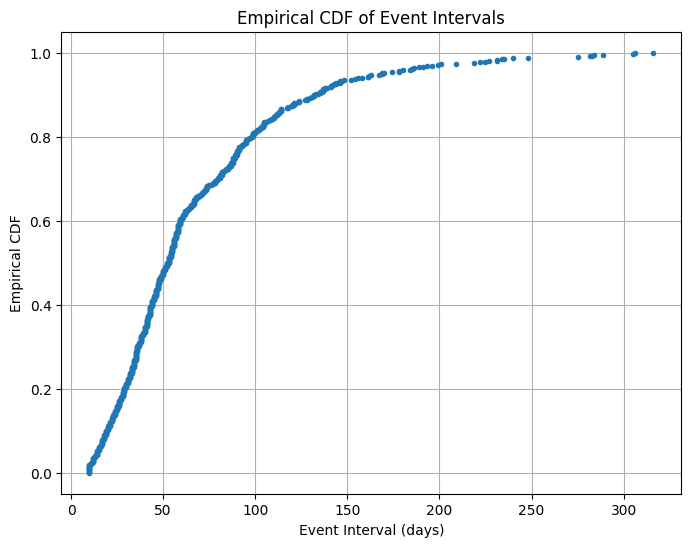

Cutoff value for event intervals: 98.0
Trimmed data:


,pnr,eksd,ATC,prev_eksd,event.interval
1,1,2020-04-20,medA,2020-03-02,49.0
2,1,2020-05-20,medA,2020-04-20,30.0
3,1,2020-06-14,medA,2020-05-20,25.0
10,2,2020-04-23,medA,2020-01-26,88.0
11,2,2020-06-12,medA,2020-04-23,50.0


In [5]:
def trim_outliers(df_sub, cutoff_percentile=0.8, plot_ecdf=True):
    intervals = df_sub['event.interval'].values
    sorted_intervals = np.sort(intervals)
    cdf_vals = np.arange(1, len(sorted_intervals)+1) / len(sorted_intervals)
    
    if plot_ecdf:
        plt.figure(figsize=(8, 6))
        plt.plot(sorted_intervals, cdf_vals, marker='.', linestyle='none')
        plt.xlabel('Event Interval (days)')
        plt.ylabel('Empirical CDF')
        plt.title('Empirical CDF of Event Intervals')
        plt.grid(True)
        plt.show()
    
    # Find the index where cdf ~ cutoff_percentile
    cutoff_index = np.searchsorted(cdf_vals, cutoff_percentile)
    if cutoff_index < len(sorted_intervals):
        cutoff_value = sorted_intervals[cutoff_index]
    else:
        cutoff_value = sorted_intervals[-1]
    
    # Keep intervals <= cutoff_value
    df_trunc = df_sub[df_sub['event.interval'] <= cutoff_value].copy()
    
    return df_trunc, cutoff_value

df_trimmed, cutoff = trim_outliers(df_temporal)
print(f"Cutoff value for event intervals: {cutoff}")
print("Trimmed data:")
df_trimmed.head()

#### Random Sampling & Standardization📝
Optionally, you can sample 1 (or more) interval(s) per patient if you want to reduce the dataset or mimic the R approach that picks a random row per pnr. Then, standardize the log(event.interval).

In [67]:
def random_sample_and_standardize(df_trunc, sample_per_patient=1, random_state=123):
    # Group by pnr and sample
    df_list = []
    groups = df_trunc.groupby('pnr')
    
    for pnr_id, group_df in groups:
        n_rows = len(group_df)
        n_sample = min(sample_per_patient, n_rows)
        df_list.append(group_df.sample(n=n_sample, random_state=random_state))
    
    df_sampled = pd.concat(df_list).sort_values(by=['pnr','eksd']).reset_index(drop=True)
    
    # Log-transform
    intervals_log = np.log(df_sampled['event.interval'].values.reshape(-1,1))
    
    # Scale
    intervals_scaled = scale(intervals_log)
    
    return intervals_scaled, df_sampled

intervals_scaled, df_sampled = random_sample_and_standardize(df_trimmed)

print("Sampled and standardized data:")
df_sampled.head()

Sampled and standardized data:


,pnr,eksd,ATC,prev_eksd,event.interval
0,1,2020-04-20,medA,2020-03-02,49.0
1,2,2020-06-12,medA,2020-04-23,50.0
2,3,2020-05-25,medA,2020-04-07,48.0
3,4,2020-08-19,medA,2020-07-19,31.0
4,5,2020-02-19,medA,2020-01-15,35.0


#### Clustering ✨
Uses silhouette analysis to pick the best k from k_range, then runs final K-means on intervals_scaled. Attaches the cluster assignments to df_sampled.

#### Different Cluster Evaluation Metrics
The Sessa Empirical Estimator (SEE) process computes temporal refill intervals and then clusters these intervals to derive a typical “filled‐prescription duration.
* **Assess Cluster Quality from Multiple Perspectives:**
    * Silhouette Score evaluates both cohesion (how closely grouped the points in a cluster are) and separation (how distinct a cluster is from its neighbors).
    * Calinski–Harabasz Index emphasizes between-cluster dispersion relative to within-cluster variance.
    * Davies–Bouldin Index penalizes clusters that are not well separated, although lower values indicate better clustering.
    * Dunn Index (custom) favors clusters that are both compact and well separated.
    * Entropy-based metrics can quantify the “disorder” or overlap among clusters.

##### Dunn Index
The Davies-Bouldin Index evaluates the compactness and separation of clusters. Lower values indicate better clustering. Let 
**K** be the total number of points.

In [7]:
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]  # ignore noise
    if len(unique_labels) < 2:
        return np.nan
    # Intra-cluster distances (diameters)
    diameters = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) < 2:
            diameters.append(0)
        else:
            dists = pdist(cluster_points)
            diameters.append(np.max(dists))
    max_diameter = np.max(diameters)
    
    # Inter-cluster distances
    inter_dists = []
    for i, label_i in enumerate(unique_labels):
        for label_j in unique_labels[i+1:]:
            points_i = X[labels == label_i]
            points_j = X[labels == label_j]
            inter_dists.append(np.min(cdist(points_i, points_j)))
    min_inter = np.min(inter_dists)
    return min_inter / max_diameter if max_diameter > 0 else np.nan

##### Entropy Metric
 Compute a simple entropy metric based on the distribution of points across clusters.
    Noise (-1) is ignored.
    Lower entropy indicates less uncertainty (better clustering).

In [8]:
def entropy_metric(labels):
    unique, counts = np.unique(labels, return_counts=True)
    if -1 in unique:
        idx = unique != -1
        unique = unique[idx]
        counts = counts[idx]
    proportions = counts / counts.sum()
    # Shannon entropy
    entropy = -np.sum(proportions * np.log(proportions + 1e-10))
    return entropy

In [17]:
def compare_metrics_across_k(intervals_scaled, k_values=range(2, 11), random_state=123):
    entropy_scores = []
    silhouette_scores = []
    db_scores = []
    
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=random_state).fit(intervals_scaled)
        labels = km.labels_
        
        # Entropy (lower is better)
        e_score = entropy_metric(labels)
        
        # Silhouette (higher is better)
        s_score = silhouette_score(intervals_scaled, labels)
        
        # Davies-Bouldin (lower is better)
        d_score = davies_bouldin_score(intervals_scaled, labels)
        
        entropy_scores.append(e_score)
        silhouette_scores.append(s_score)
        db_scores.append(d_score)
    
    # Plot
    plt.figure(figsize=(7,5))
    # Entropy (lower is better)
    plt.plot(k_values, entropy_scores, 'o-', label="Entropy Score (Lower is Better)", color='blue')
    # Silhouette (higher is better)
    plt.plot(k_values, silhouette_scores, 'o-', label="Silhouette Score (Higher is Better)", color='green')
    # Davies-Bouldin (lower is better)
    plt.plot(k_values, db_scores, '^-', label="Davies-Bouldin Index (Lower is Better)", color='orange')
    
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Score")
    plt.title("Comparison of Entropy, Silhouette Score, and Davies-Bouldin Index")
    plt.grid(True)
    plt.legend()
    plt.show()

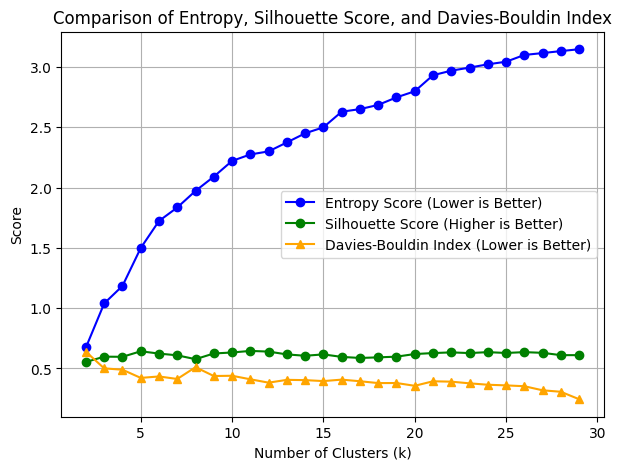

In [37]:
def cluster_distances(intervals_scaled, df_sampled, k_range=range(2,6), score_method="silhouette", random_state=123):
    direction = {
        "silhouette": 1,
        "calinski_harabasz": 1,
        "davies_bouldin": -1,
        "dunn": 1,
        "entropy": -1
    }
    
    scores = {}
    best_score = -np.inf
    best_k = None
    
    # Loop over candidate k values
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state).fit(intervals_scaled)
        labels = km.labels_
        if score_method == "silhouette":
            score = silhouette_score(intervals_scaled, labels)
        elif score_method == "davies_bouldin":
            score = davies_bouldin_score(intervals_scaled, labels)
        elif score_method == "entropy":
            score = entropy_metric(labels)
        else:
            raise ValueError("Unsupported score_method. Choose among silhouette, davies_bouldin, or entropy.")
        
        # Multiply by direction to ensure higher is better for all.
        scores[k] = direction[score_method] * score
        if scores[k] > best_score:
            best_score = scores[k]
            best_k = k
    
    # Run final KMeans with the best_k
    final_km = KMeans(n_clusters=best_k, random_state=random_state).fit(intervals_scaled)
    df_sampled['cluster'] = final_km.labels_
    return df_sampled, best_k, scores

df_clustered_sampled, best_k, score_dict = cluster_distances(intervals_scaled, df_sampled, k_range=range(2,6), random_state=123)

# visualize the metrics
compare_metrics_across_k(intervals_scaled, k_values=range(2,30))

#### Interpretation of the Plot 📄
Based on what is shown in the plot, we interpret the following:
1. Entropy (Blue, Lower is Better)
    * The entropy value increases as 𝑘 grows from 2 to 30
    * This suggests that splitting into more clusters makes the distribution of points more “disordered,” indicating that fewer clusters particularly 𝑘 = 2 yield a lower (better) entropy.
2. Silhouette (Green, Higher is Better)
    * The silhouette score remains relatively stable or slightly decreases as 𝑘 goes beyond 2 or 3.
    * There’s no significant improvement at higher 𝑘. Instead, the curve suggests that adding more clusters does not yield better cohesion or separation.
3. Davies–Bouldin Index (Red, Lower is Better)
    * This metric also does not show a clear improvement with larger 𝑘.
    * If anything, it may stay flat or get slightly worse, indicating no gain in cluster compactness/separation.

Overall Conclusion
* Entropy becomes significantly higher with large 𝑘, indicating more “fragmentation.”
* Silhouette remains constant or declines, suggesting no benefit in cluster separation.
* Davies–Bouldin does not clearly drop to a better value.
    
        Hence, the best 𝑘 is likely on the low end (2 or 3) rather than at the high end. Large numbers of clusters tend to over-segment the data, increasing entropy, reducing silhouette, and offering no improvement in Davies–Bouldin.

#### Duration Estimation ⌛
For each cluster, computes min, max, and median event.interval. Merges cluster info back to df_sub. Rows not in df_clustered get a fallback 'median' from the most frequent cluster.

In [33]:
def estimate_duration(df_sub, df_clustered):
    # Calculate cluster stats on the cluster-labeled sample
    cluster_stats = df_clustered.groupby('cluster')['event.interval'].agg(['min','max','median']).reset_index()
    
    # Merge cluster stats into df_clustered
    df_clustered = pd.merge(
        df_clustered,
        cluster_stats[['cluster','median']],
        on='cluster',
        how='left',
        suffixes=('','_clust')
    )
    
    # Determine fallback median from the most frequent cluster
    freq_cluster = df_clustered['cluster'].value_counts().idxmax()
    fallback_median = cluster_stats.loc[cluster_stats['cluster']==freq_cluster, 'median'].values[0]
    
    # Merge cluster info back to the entire df_sub
    # We'll match on ['pnr','eksd'] because that's how intervals are identified
    df_merged = pd.merge(
        df_sub,
        df_clustered[['pnr','eksd','cluster','median']],
        on=['pnr','eksd'],
        how='left'
    )
    
    # Fill missing cluster/median with fallback
    df_merged['cluster'] = df_merged['cluster'].fillna(-1)
    df_merged['median'] = df_merged['median'].fillna(fallback_median)
    
    return df_merged

km_final = KMeans(n_clusters=best_k, random_state=123).fit(intervals_scaled)
df_sampled['cluster'] = km_final.labels_

df_merged = estimate_duration(df_temporal, df_clustered_sampled)
print("Final data with estimated durations:")
df_merged.head()

Final data with estimated durations:


,pnr,eksd,ATC,prev_eksd,event.interval,cluster,median
0,1,2020-04-20,medA,2020-03-02,49.0,4.0,57.0
1,1,2020-05-20,medA,2020-04-20,30.0,-1.0,36.5
2,1,2020-06-14,medA,2020-05-20,25.0,-1.0,36.5
3,1,2020-12-01,medA,2020-06-14,170.0,-1.0,36.5
4,2,2020-04-23,medA,2020-01-26,88.0,-1.0,36.5


### Visualization of the Clusters 📊

The `see_assumption_py` function visualizes the distribution of prescription durations for each patient using a boxplot. Here are the steps it performs:

1. **Sort and Compute Previous Prescription Date**:
    - The data is sorted by patient number (`pnr`) and prescription fill date (`eksd`). The previous prescription fill date (`prev_eksd`) for each patient is computed using the `shift(1)` method. Rows without a previous prescription date are dropped.

2. **Calculate Duration**:
    - The duration between consecutive prescription fills (`Duration`) is calculated in days.

3. **Create Sequence Index**:
    - Within each patient group, a sequence index (`P Number`) is created to represent the order of prescriptions.

4. **Boxplot Visualization**:
    - A boxplot is created to visualize the distribution of `Duration` for each `P Number`. The median of medians for the `Duration` across all patients is computed and displayed as a horizontal red dashed line on the boxplot.

5. **Plot Customization**:
    - The plot is customized with a title indicating the ATC code of the medication. The layout is adjusted for better visualization.

In [34]:
def see_boxplot(data, title="Durations vs Patient Number"):
    df_temp = data.copy()
    # Sort by pnr, eksd and compute the Duration
    df_temp = df_temp.sort_values(by=['pnr','eksd'])
    df_temp['prev_eksd'] = df_temp.groupby('pnr')['eksd'].shift(1)
    df_temp.dropna(subset=['prev_eksd'], inplace=True)
    df_temp['Duration'] = (df_temp['eksd'] - df_temp['prev_eksd']).dt.days
    
    # Create a sequential index (p_number)
    df_temp['P Number'] = df_temp.groupby('pnr').cumcount() + 1
    
    # Plot
    fig, ax = plt.subplots(figsize=(5,4))
    sns.boxplot(data=df_temp, x='P Number', y='Duration', ax=ax, color='lightgray')
    
    # median of medians
    medians_of_medians = df_temp.groupby('pnr')['Duration'].median().median()
    ax.axhline(medians_of_medians, color='red', linestyle='--', label='Median of medians')
    
    # Use first row's ATC as a label if desired
    atc_code = df_temp['ATC'].iloc[0] if 'ATC' in df_temp.columns else 'Unknown'
    ax.set_title(f"{title} for {atc_code}\nRed Dashed = Median of Medians")
    plt.tight_layout()
    plt.show()


In [35]:
from scipy.spatial import ConvexHull

def plot_clusters_2D(data, title="Cluster Plot (p_number vs. Duration)"):
    df_temp = data.copy()
    
    # Ensure 'Duration' and 'P Number' exist
    if 'Duration' not in df_temp.columns or 'P Number' not in df_temp.columns:
        # replicate logic from see_boxplot to create them
        df_temp = df_temp.sort_values(by=['pnr','eksd'])
        df_temp['prev_eksd'] = df_temp.groupby('pnr')['eksd'].shift(1)
        df_temp.dropna(subset=['prev_eksd'], inplace=True)
        df_temp['Duration'] = (df_temp['eksd'] - df_temp['prev_eksd']).dt.days
        df_temp['P Number'] = df_temp.groupby('pnr').cumcount() + 1
    
    # If 'cluster' doesn't exist, just set everything to 0
    if 'cluster' not in df_temp.columns:
        df_temp['cluster'] = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(6,5))
    
    # We'll color each cluster differently
    clusters = sorted(df_temp['cluster'].unique())
    
    for cl in clusters:
        # subset the cluster
        df_cl = df_temp[df_temp['cluster'] == cl]
        xvals = df_cl['P Number'].values
        yvals = df_cl['Duration'].values
        
        # Scatter
        ax.scatter(xvals, yvals, label=f"Cluster {cl}", alpha=0.7)
        
        # Draw a convex hull if at least 3 points
        if len(df_cl) >= 3:
            points_2d = np.column_stack((xvals, yvals))
            hull = ConvexHull(points_2d)
            # Plot polygon
            hull_points = hull.vertices.tolist() + [hull.vertices[0]]
            ax.fill(points_2d[hull_points,0], points_2d[hull_points,1],
                    alpha=0.2)
    
    ax.set_xlabel("P Number")
    ax.set_ylabel("Duration")
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()


### Testing the code 🚀

This code block calls two functions: `See_py(df)` and `see_assumption_py(df_clustered)`. The `See_py(df)` function applies the Sessa Empirical Estimator (SEE) method to the dataframe `df` using the default ATC code.


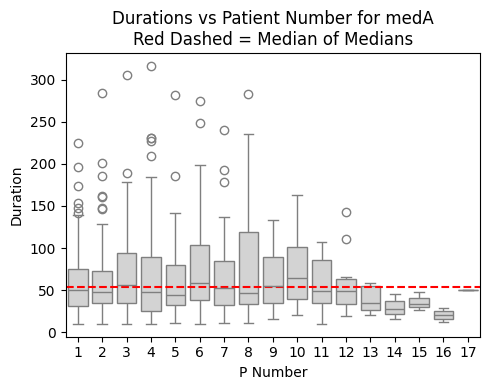

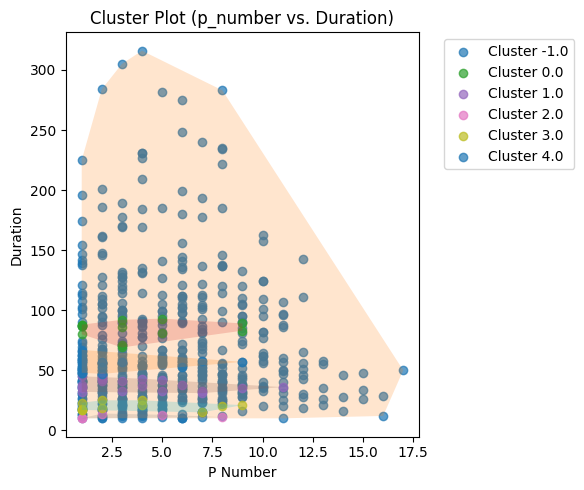

In [36]:
#######################
# 4.a Run the functions with medA
#######################
see_boxplot(df_merged)
plot_clusters_2D(df_merged)

### Insights for medA SEE Results 📊
Based on the boxplot:
1. The first few p numbers show large spreads and high outliers with some going over the 300 day mark. This suggests that, at first, patients rarely go for in-between refills or started therapy late. 

2. The median of medians (red-dash line) shows that half the patient medians are below 50 days and the other half above. 

3. We can also see that as the p number increases, the plot trends lower, going below 60 days. This means that once a patient is on a stable medication schedule, they go for smaller intervals of refills.

4. From the third insight, we can also say that patients that reach p number 14 higher are refilling more consistently than those on the first numbers with fewer outliers.

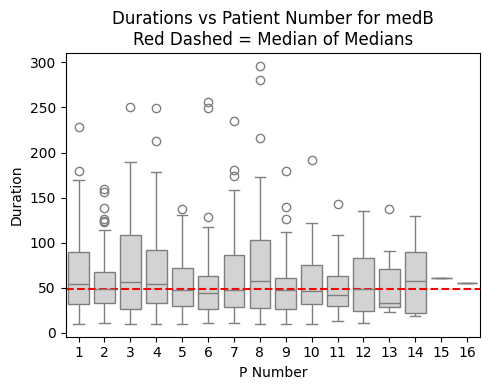

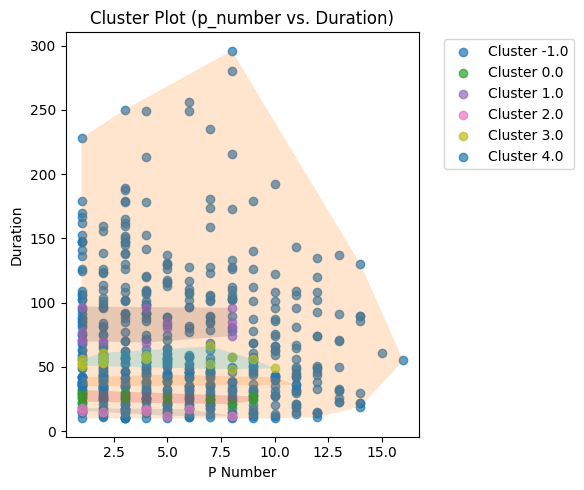

In [39]:
#######################
# 4.b Run the functions with medB
#######################

df_temporal_b = compute_temporal_distances(df, atc_code='medB')

df_trimmed_b, cutoff_b = trim_outliers(df_temporal_b, plot_ecdf=False)

intervals_scaled_b, df_sampled_b = random_sample_and_standardize(df_trimmed_b)

df_clustered_sampled_b, best_k_b, scores_b = cluster_distances(intervals_scaled_b, df_sampled_b)

df_merged_b = estimate_duration(df_temporal_b, df_clustered_sampled_b)

see_boxplot(df_merged_b)
plot_clusters_2D(df_merged_b)

### Insights for medB SEE Results 📊
Based on the boxplot:
1. Like medA, the highest outliers (100 ~ 300 days) appear in the early p_numbers. These may be patients who waited an unusually long time for a second prescription or discontinued and then restarted after the gap.

2. The median of medians (red-dash line) shows to be around 50-55 days for the medB patients.

3. For many patients, intervals stabilize around 50–60 days as p_number increases. The red dashed line near 50–55 days confirms that a typical refill cycle for many medB users hovers around 7–8 weeks.

This pattern often reflects the reality that some patients start therapy irregularly but then settle into a more stable refill schedule over time.

## Insights for the Sessa K Means Model 📈
The data used in this clustering assignment was generated as a simulation for actual data from randomized seed of numbers. By combining SEE’s outlier truncation with K-means, you get robust “typical” intervals for each cluster, ignoring top-percentile gaps that might not reflect normal usage. 

In real-world pharmacoepidemiology, these clusters help define standard refill durations per patient or per cluster, improving the accuracy of treatment-episode construction.

    Overall, using SEE with K-means on these two datasets reveals distinct refill‐interval patterns and helps standardize durations for subsequent pharmacoepidemiological analyses—whether for computing adherence, defining treatment episodes, or identifying patients with potentially suboptimal medication use.

## Substituting K-Means with an Alternative Clustering Algorithm 🔄
K-means has well-known disadvantages—it assumes clusters are spherical, it needs to predetermine the number of clusters, and is very sensitive to outliers. To overcome these issues, you could try using DBSCAN, which can automatically identify the number of clusters and detect noise. This will replace step 4 of the code process.

In [ ]:
def cluster_dbscan(intervals_scaled, df_sampled, eps=0.3, min_samples=3):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(intervals_scaled)
    df_sampled['cluster'] = labels
    return df_sampled, labels

In [63]:
# using dbscan instead of kmeans with silhouette sampling
df_clustered_sampled_dbscans, labels = cluster_dbscan(intervals_scaled, df_sampled, eps=0.3, min_samples=3)
print("DBSCAN cluster labels (noise points labeled as -1):")
df_clustered_sampled_dbscans[['pnr', 'eksd', 'event.interval', 'cluster']].head()

DBSCAN cluster labels (noise points labeled as -1):


,pnr,eksd,event.interval,cluster
0,1,2020-04-20,49.0,0
1,2,2020-06-12,50.0,0
2,3,2020-05-25,48.0,0
3,4,2020-08-19,31.0,0
4,5,2020-02-19,35.0,0


In [64]:
# merging dbscan cluster results
df_merged_dbscans = estimate_duration(df_temporal, df_clustered_sampled_dbscans)
print("Final data with estimated durations (merged):")
df_merged.head()

Final data with estimated durations (merged):


,pnr,eksd,ATC,prev_eksd,event.interval,cluster,median
0,1,2020-04-20,medA,2020-03-02,49.0,4.0,57.0
1,1,2020-05-20,medA,2020-04-20,30.0,-1.0,36.5
2,1,2020-06-14,medA,2020-05-20,25.0,-1.0,36.5
3,1,2020-12-01,medA,2020-06-14,170.0,-1.0,36.5
4,2,2020-04-23,medA,2020-01-26,88.0,-1.0,36.5


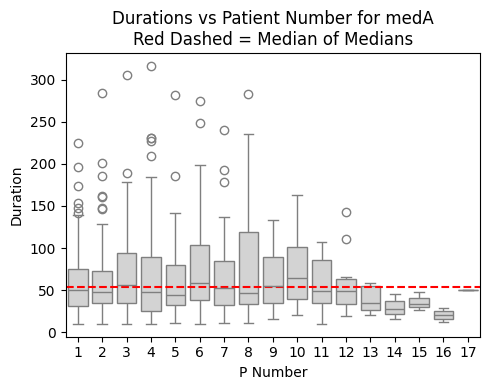

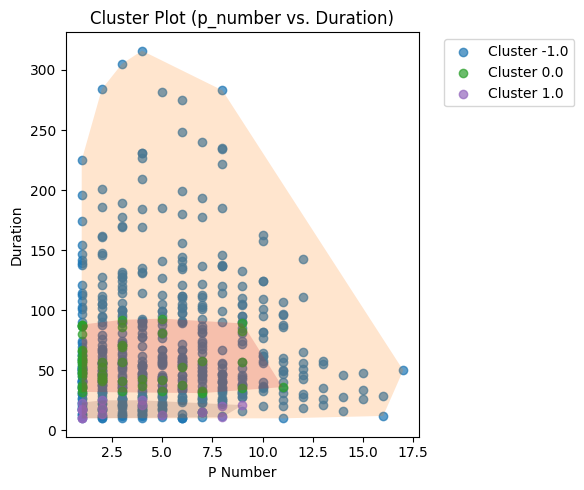

In [65]:
see_boxplot(df_merged_dbscans)
plot_clusters_2D(df_merged_dbscans)

### Insights from DBSCANS compared to KMeans ⚖️
Compared to KMeans clustering, DBScans can form fewer clusters than the previous method. This is because K-means, by design, produces as many clusters as you specify (or choose via silhouette), and every point belongs to one of those clusters.

If your intervals have only one dense region, DBSCAN will treat that region as a single cluster, with everything else flagged as noise. K-means, however, would “slice” that region into multiple clusters, each assigned a separate label.

Both plots show a very similar distribution of refill durations—because the underlying data is the same. The difference lies in how each algorithm labels the points (i.e., which intervals get flagged as noise vs. assigned to a cluster).

Comparing the two plots, the main difference is that DBSCAN can isolate outliers (noise) and typically has fewer “dense” clusters, whereas K-means divides all points among a fixed number of clusters. The actual boxplots of raw durations remain similar because they reflect the same underlying distribution; the color labeling reveals how each algorithm treats those points.

## Overall Conclusion 🏁
The Sessa Empirical Estimator (SEE) process provides a structured approach for calculating and clustering temporal distances between prescription fills. Whether using K-means or alternative clustering methods like DBSCAN, the following key insights emerge:
1. Core Functionality of SEE:
    * **Temporal Distance Calculation.** SEE computes the number of days between consecutive prescription events for each patient, serving as the basis for further analysis.
   *  **Outlier Trimming**. By using the empirical cumulative distribution function (ECDF) to remove the top 20% of intervals, SEE focuses on the core refill patterns.
2. Using K-means:
    * **Forced Cluster Membership.** K-means assigns every data point to a cluster, which can be beneficial when you want a fixed number of groups.
    * **Optimal Cluster Determination**. Silhouette analysis is used to select the best number of clusters, leading to meaningful centroid estimates (e.g., median refill durations) for each cluster.
    * **Interpretation**. The resulting clusters represent distinct refill patterns, but even if outliers exist, K-means will incorporate them into one of the clusters.
3. Using Alternative Clustering Methods (e.g., DBSCAN):
    * **Noise Identification**. Methods like DBSCAN can identify outliers (noise points) by not forcing every point into a cluster. Noise points are typically labeled as -1.
    * **Cluster Structure**. DBSCAN might produce fewer clusters or even a single main cluster, with clear isolation of anomalous refill patterns.


            In practice, comparing results from different clustering algorithms can provide deeper insights into the heterogeneity of refill patterns, helping to identify both common and anomalous behaviors.